In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm

In [2]:
data = pd.read_csv('../Data/clear_df.csv')
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,latitude,longitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
0,51.938,-10.241,0.0,17.9,16.5,15.5,17.6,86.0,1025.9,9.0
1,53.428,-6.241,0.0,0.5,-0.2,-1.5,5.5,86.0,1011.7,12.0
2,55.372,-7.339,0.0,10.5,9.2,7.8,10.6,83.0,1006.4,10.0
3,53.727,-7.981,0.0,-2.3,-2.5,-3.0,4.9,95.0,1020.0,2.0
4,53.922,-9.572,0.6,8.4,7.9,7.3,10.2,92.0,997.3,5.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4214711 entries, 0 to 4214710
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   rain       float64
 3   temp       float64
 4   wetb       float64
 5   dewpt      float64
 6   vappr      float64
 7   rhum       float64
 8   msl        float64
 9   wdsp       float64
dtypes: float64(10)
memory usage: 321.6 MB


### Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV) .

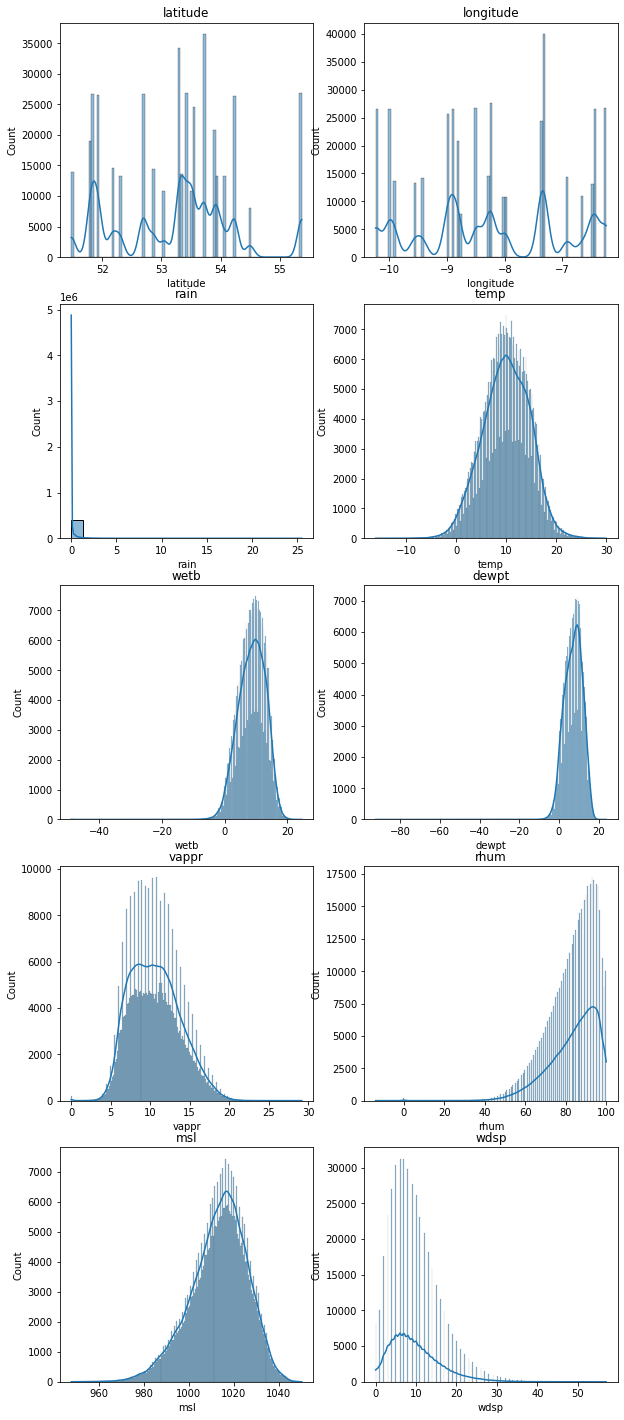

In [75]:
n_rows = 5
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 25))
for i, column in enumerate(data):
    sns.histplot(data[column].sample(frac=0.1), ax=axes[i // n_cols, i % n_cols], kde=True).set_title(column)

### Step 2. You need to make an estimation of multivariate mathematical expectation and variance.

In [47]:
data.mean()

latitude       53.212696
longitude      -8.226245
rain            0.125007
temp           10.010837
wetb            8.703244
dewpt           7.262042
vappr          10.607646
rhum           83.720438
msl          1013.304447
wdsp            9.669168
dtype: float64

In [163]:
data.var()

latitude       0.986966
longitude      1.537140
rain           0.236866
temp          21.777986
wetb          18.343602
dewpt         19.906953
vappr          9.924274
rhum         138.739603
msl          158.427301
wdsp          38.176474
dtype: float64

### Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

In [57]:
data[(data["temp"] > 15) & (data["temp"] < 16)].mean()

latitude       53.097541
longitude      -8.336038
rain            0.116517
temp           15.480533
wetb           13.694001
dewpt          12.106832
vappr          14.276508
rhum           81.012076
msl          1014.417929
wdsp            9.553324
dtype: float64

In [60]:
data[(data["temp"] > 15) & (data["temp"] < 16)].var()

latitude       1.012107
longitude      1.606466
rain           0.317620
temp           0.066436
wetb           1.942835
dewpt          6.707386
vappr          5.146739
rhum         166.566050
msl           79.194672
wdsp          26.980483
dtype: float64

### Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [4]:
def get_correlation(x, y):
    r, p_value = stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    return r, p_value, (lo_z, hi_z)

In [155]:
correlations = np.zeros_like(data.corr(), dtype=np.float32)
correlations_p_value = np.zeros_like(data.corr(), dtype=np.float32)
correlations_interval = np.zeros_like(data.corr(), dtype=object)

In [156]:
for i in tqdm(range(correlations.shape[0])):
    for j in range(correlations.shape[1]):
        r, p_value, interval = get_correlation(data.iloc[:, i], data.iloc[:, j])
        correlations[i, j] = r
        correlations_p_value[i, j] = p_value
        correlations_interval[i][j] = f"{round(interval[0], 3)} {round(interval[1], 3)}"

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/39/sbhbfb514339n_2mzhldqjm40000gn/T/ipykernel_89588/3326382169.py:3: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)
100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


In [157]:
mask = np.zeros_like(data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

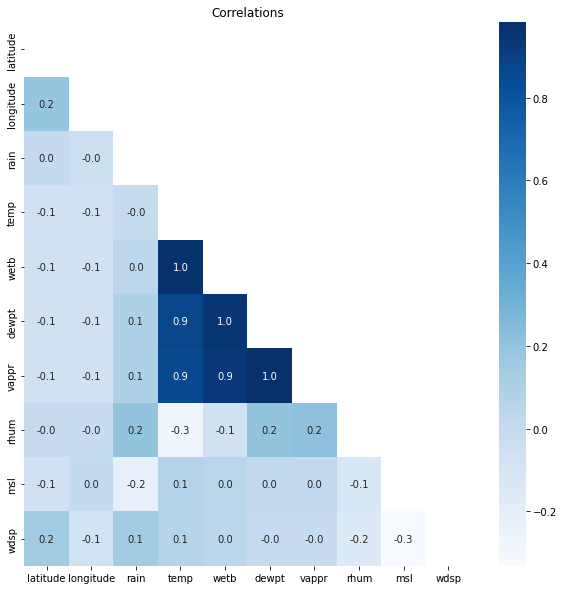

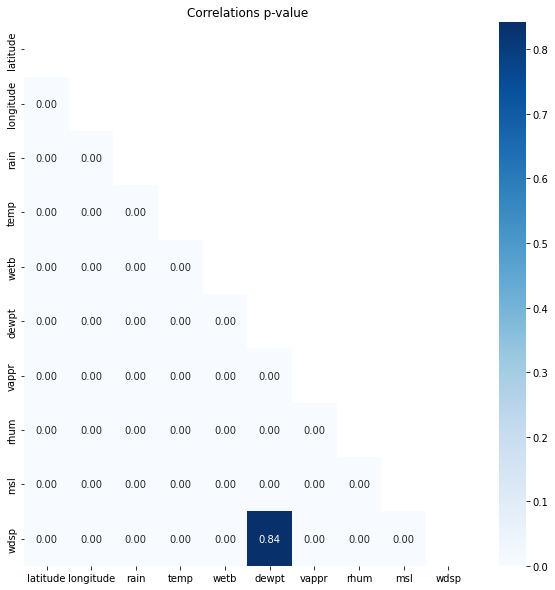

,latitude,longitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
latitude,inf inf,0.19 0.192,0.004 0.006,-0.065 -0.064,-0.07 -0.068,-0.07 -0.068,-0.073 -0.071,-0.008 -0.006,-0.063 -0.061,0.155 0.157
longitude,0.19 0.192,inf inf,-0.043 -0.042,-0.064 -0.062,-0.074 -0.072,-0.074 -0.072,-0.07 -0.068,-0.011 -0.009,0.002 0.004,-0.079 -0.077
rain,0.004 0.006,-0.043 -0.042,14.373 14.375,-0.004 -0.002,0.042 0.044,0.09 0.092,0.089 0.091,0.199 0.201,-0.226 -0.224,0.143 0.144
temp,-0.065 -0.064,-0.064 -0.062,-0.004 -0.002,inf inf,2.049 2.051,1.361 1.363,1.299 1.301,-0.292 -0.29,0.071 0.073,0.064 0.066
wetb,-0.07 -0.068,-0.074 -0.072,0.042 0.044,2.049 2.051,inf inf,1.895 1.897,1.747 1.749,-0.065 -0.063,0.042 0.044,0.04 0.042
dewpt,-0.07 -0.068,-0.074 -0.072,0.09 0.092,1.361 1.363,1.895 1.897,16.155 16.157,2.372 2.374,0.203 0.205,0.007 0.009,-0.001 0.001
vappr,-0.073 -0.071,-0.07 -0.068,0.089 0.091,1.299 1.301,1.747 1.749,2.372 2.374,15.222 15.224,0.216 0.218,0.014 0.016,-0.012 -0.01
rhum,-0.008 -0.006,-0.011 -0.009,0.199 0.201,-0.292 -0.29,-0.065 -0.063,0.203 0.205,0.216 0.218,inf inf,-0.126 -0.124,-0.153 -0.151
msl,-0.063 -0.061,0.002 0.004,-0.226 -0.224,0.071 0.073,0.042 0.044,0.007 0.009,0.014 0.016,-0.126 -0.124,inf inf,-0.346 -0.344
wdsp,0.155 0.157,-0.079 -0.077,0.143 0.144,0.064 0.066,0.04 0.042,-0.001 0.001,-0.012 -0.01,-0.153 -0.151,-0.346 -0.344,15.003 15.005


In [158]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlations, mask=mask, annot=True, fmt='.1f', ax=ax, cmap='Blues', xticklabels=data.columns, yticklabels=data.columns,).set_title('Correlations')
plt.show()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlations_p_value, mask=mask, annot=True, fmt='.2f', ax=ax, cmap='Blues', xticklabels=data.columns, yticklabels=data.columns,).set_title('Correlations p-value')
plt.show()

pd.DataFrame(correlations_interval, columns=data.columns, index=data.columns)

### Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

In [5]:
Y = data[["temp"]]
X = data.drop("temp", axis=1)

In [6]:
Y.head()

,temp
0,17.9
1,0.5
2,10.5
3,-2.3
4,8.4


In [7]:
X.head()

,latitude,longitude,rain,wetb,dewpt,vappr,rhum,msl,wdsp
0,51.938,-10.241,0.0,16.5,15.5,17.6,86.0,1025.9,9.0
1,53.428,-6.241,0.0,-0.2,-1.5,5.5,86.0,1011.7,12.0
2,55.372,-7.339,0.0,9.2,7.8,10.6,83.0,1006.4,10.0
3,53.727,-7.981,0.0,-2.5,-3.0,4.9,95.0,1020.0,2.0
4,53.922,-9.572,0.6,7.9,7.3,10.2,92.0,997.3,5.0


In [9]:
for column in X.columns:
    r, p_value, interval = get_correlation(data.loc[:, column], Y.iloc[:, 0])
    print(f"Correlation for {column} and temp: {round(r, 3)}, p_value: {round(p_value, 3)}, confidence intervals: ({round(interval[0], 3)}, {round(interval[0], 3)})")

Correlation for latitude and temp: -0.064, p_value: 0.0, confidence intervals: (-0.065, -0.065)
Correlation for longitude and temp: -0.063, p_value: 0.0, confidence intervals: (-0.064, -0.064)
Correlation for rain and temp: -0.003, p_value: 0.0, confidence intervals: (-0.004, -0.004)
Correlation for wetb and temp: 0.967, p_value: 0.0, confidence intervals: (2.049, 2.049)
Correlation for dewpt and temp: 0.877, p_value: 0.0, confidence intervals: (1.361, 1.361)
Correlation for vappr and temp: 0.862, p_value: 0.0, confidence intervals: (1.299, 1.299)
Correlation for rhum and temp: -0.283, p_value: 0.0, confidence intervals: (-0.292, -0.292)
Correlation for msl and temp: 0.072, p_value: 0.0, confidence intervals: (0.071, 0.071)
Correlation for wdsp and temp: 0.065, p_value: 0.0, confidence intervals: (0.064, 0.064)


### Step 6 and 7. Build regression model and make an analysis of multicollinearity and regularization (if needed). Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
print('Model weights:', model.coef_)
print('Model bias:', model.intercept_)

Model weights: [[ 3.31333465e-03  9.32681424e-03  3.18916014e-02  3.08877903e-01
   5.35011934e-01  2.65697614e-01 -1.61460739e-01  4.69590935e-04
  -4.46581160e-03]]
Model bias: [13.60028928]


/Users/alexander.semiletov/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


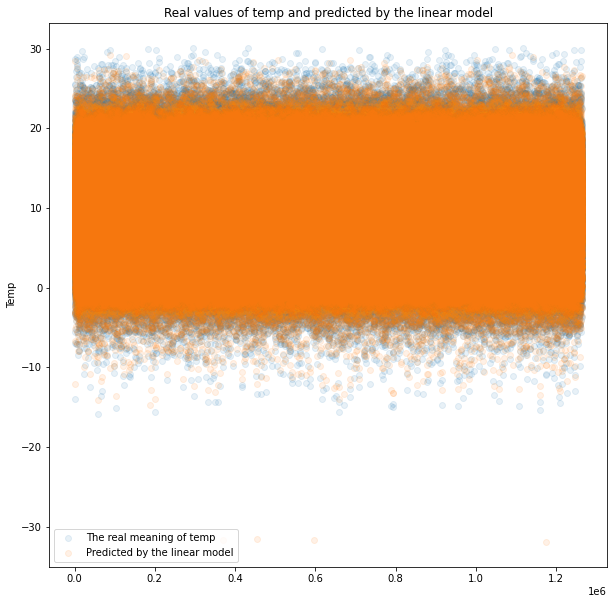

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
plt.scatter(range(X_test.shape[0]), y_test, label = u'The real meaning of temp', alpha=0.1)
plt.scatter(range(X_test.shape[0]), y_pred, label = u'Predicted by the linear model', alpha=0.1)
plt.title(u'Real values of temp and predicted by the linear model')
# plt.legend(borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.legend()
plt.ylabel(u'Temp')
plt.show()

In [15]:
print(f'R2 score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Determination coefficient: {model.score(X_test, y_test)}')

R2 score: 0.9923115101062351
MSE: 0.16745384750535852
MAE: 0.1934216467318409
Determination coefficient: 0.9923115101062351


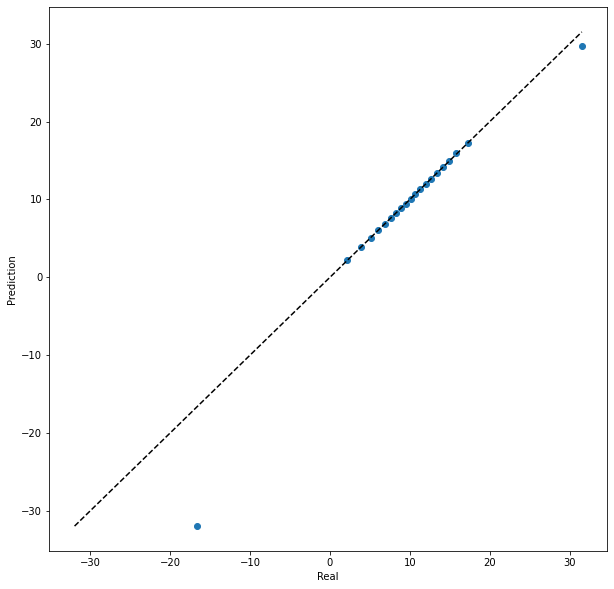

In [16]:
y_pred_all = np.array(model.predict(X))

# Plotting a quantile biplot based on real and predicted values
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(Y, percs)
qn_second = np.percentile(y_pred_all, percs)
plt.figure(figsize=(10, 10))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')
plt.show()

In [17]:
diff = y_test[:].to_numpy().reshape(-1) - y_pred[:].reshape(-1)

In [18]:
diff

array([ 0.15346714,  0.26781872, -0.05421433, ..., -7.39227879,
       -0.37475652,  0.25692723])

In [19]:
diff.mean()

-0.00021677105073528329

In [20]:
diff.std()

0.40921119304788106

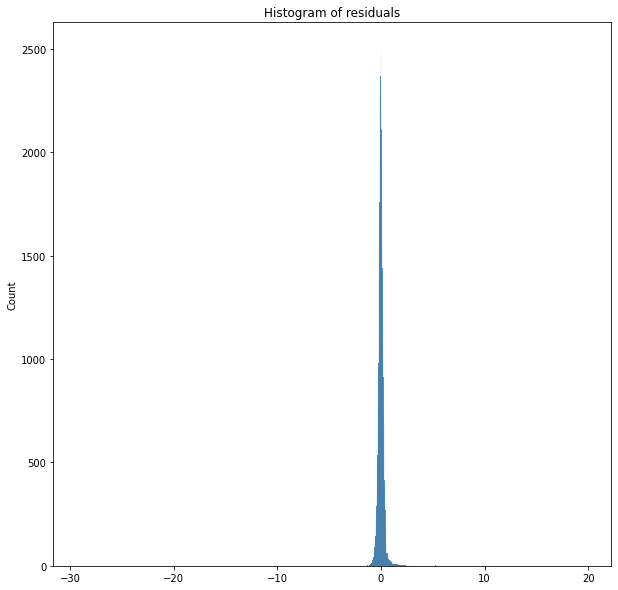

In [24]:
f, ax = plt.subplots(figsize=(10, 10))
sns.histplot(np.random.choice(diff, 100000), kde=False, ax=ax)
plt.title("Histogram of residuals")
plt.show()

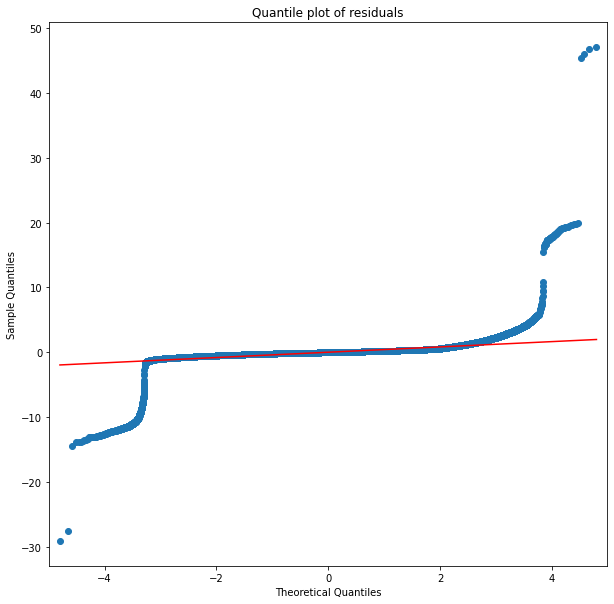

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
qqplot(diff, line='s', ax=ax)
plt.title("Quantile plot of residuals")
plt.show()

In [26]:
stat, p = shapiro(diff)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.493, p=0.000
Sample does not look Gaussian (reject H0)


/Users/alexander.semiletov/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
